In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.profiler import record_function
from datasets import load_dataset
import time
import numpy as np
import matplotlib.pyplot as plt

/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set seed for reproducibility in torch, numpy and gpu

torch.manual_seed(710)
np.random.seed(710)

In [3]:
tiny_imagenet = load_dataset("Maysee/tiny-imagenet", split="train")
tiny_imagenet[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

In [4]:
# get number of classes
num_classes = len(tiny_imagenet.features["label"].names)
num_classes

200

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# Convert to torch dataset

class TinyImageNet(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]["image"], self.dataset[idx]["label"]
        # convert x to RGB
        x = x.convert("RGB")
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tiny_imagenet_torch = TinyImageNet(tiny_imagenet, transform=transform)
type(tiny_imagenet_torch[0])

tuple

### Load model to GPU

In [7]:
torch.cuda.memory._record_memory_history(
       max_entries=10000
   )

model_gpu_usage_before = torch.cuda.memory_allocated(device)
model = models.resnet18(pretrained=True)
model.to(device)

model_gpu_usage_after = torch.cuda.memory_allocated(device)

model_gpu_usage = model_gpu_usage_after - model_gpu_usage_before

# print number of parameters in the model

print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())}")
print(f"Model GPU usage: {model_gpu_usage / 1024**2:.2f} MB")

del model


[W206 22:59:31.405157200 unwind.cpp:218] Warning: Unsupported unwinding pattern: Address not in range (function unwinderFor)
/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of parameters in the model: 11689512
Model GPU usage: 44.69 MB


### Compare effect of large batch size on memory usage

In [8]:
def fit(model, train_loader, val_loader, epochs=1, lr=0.001, break_after_num_batches=None, title=""):
    """
    Borrowed from https://github.com/francisgan/Projects/blob/97b1520443c5463af29ac3e37c0c9f8a7c58637a/DSC-Capstone/code/cnn_train.py
    """
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()


    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
        record_shapes=True,
        with_stack=True,
        profile_memory=True
    ) as prof:

        for epoch in range(epochs):
            for batch_idx, batch in enumerate(train_loader):
                prof.step()


                inputs, labels = batch
                
                with record_function("to_device"):
                    inputs, labels = inputs.to(device), labels.to(device)

                with record_function("forward"):
                    outputs = model(inputs)
                
                with record_function("backward"):
                    criterion(outputs, labels).backward()
                
                with record_function("optimizer_step"):
                    optimizer.step()
                    optimizer.zero_grad()


                if break_after_num_batches is not None and batch_idx >= break_after_num_batches:
                    break

                

    prof.export_memory_timeline(f"{title}_memory.html", device="cuda:0")

    

def clear_cuda_memory():
    # Clear memory caches
    torch.cuda.empty_cache()
    
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()
    
    # Clear memory allocated by PyTorch
    torch.cuda.synchronize()
    
    # Optional: Force garbage collection
    import gc
    gc.collect()
    
    # Print memory stats to verify
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


Proccessed for batch size 128
Allocated memory: 16.25 MB
Cached memory: 174.00 MB


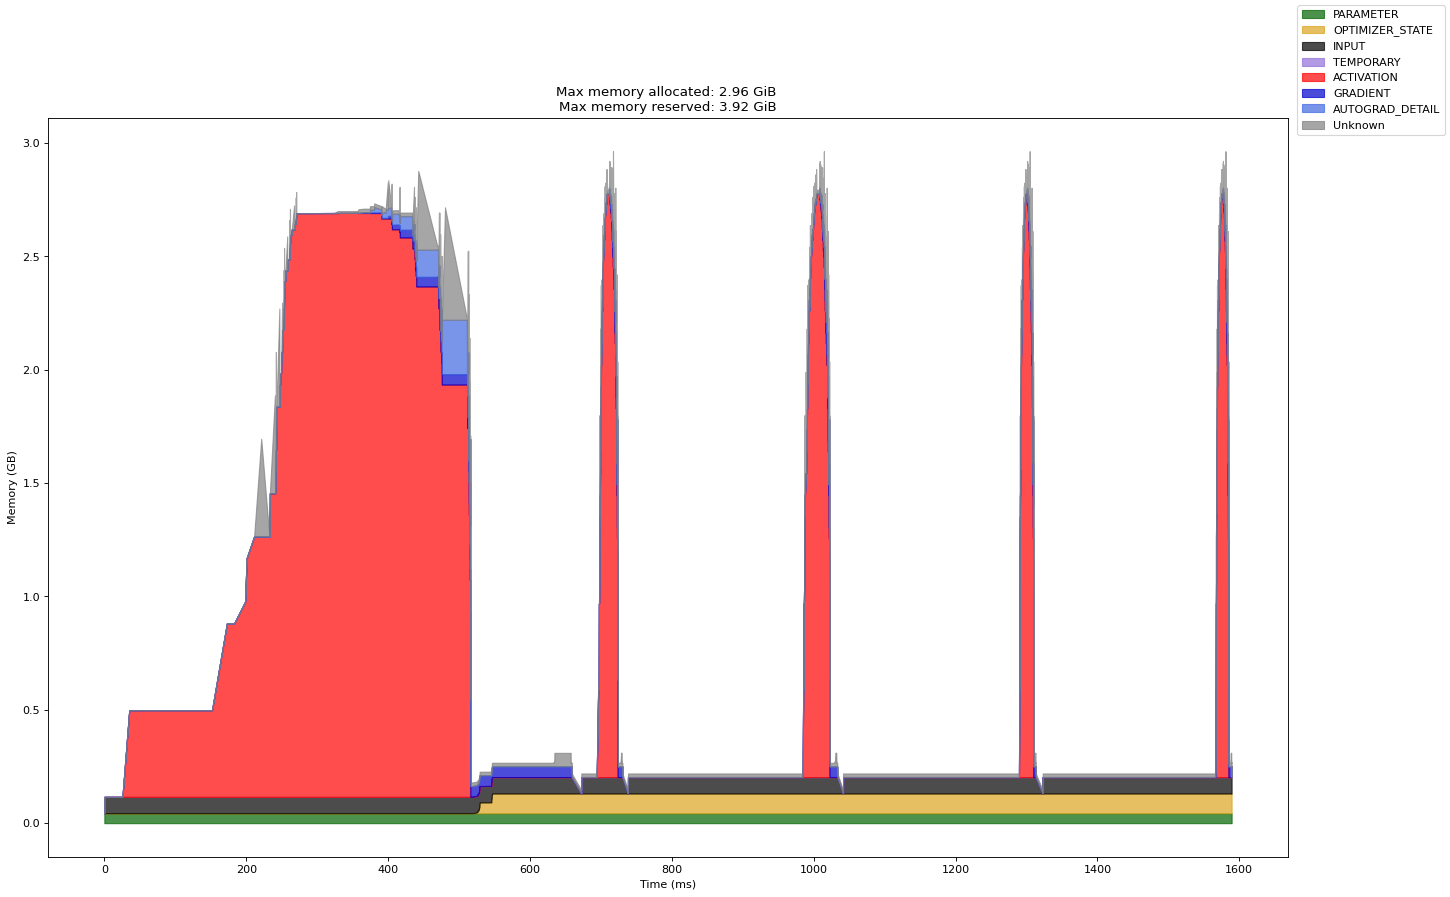

In [9]:
batch_ids = None
num_workers = 4
break_after_num_batches = 10

batch_indices = None
batch_sizes = [128]
for batch_size in batch_sizes:

    model = models.resnet18(pretrained=True)
    model.to(device)

    train_loader = torch.utils.data.DataLoader(tiny_imagenet_torch, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(tiny_imagenet_torch, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    fit(model, train_loader, val_loader, epochs=1, break_after_num_batches=break_after_num_batches, title=f"batch_size_{batch_size}")
    
    print(f"Proccessed for batch size {batch_size}")
    # clear memory
    del model
    del train_loader
    del val_loader
    clear_cuda_memory()
    time.sleep(10)






- Batchsize of 256 seems to take 4GB of memory how ?
- Model takes 44 MB. Activation seems to take the rest. How ?

### Break down memory usage in Resnet
- It takes memory to store the model, activations

In [10]:
from torch.utils import checkpoint
import torch.nn as nn
import torchvision.models as models

class ResnetCheckpointed(nn.Module):
    def __init__(self):
        super(ResnetCheckpointed, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        # Store each layer separately
        self.conv1 = self.model.conv1
        self.bn1 = self.model.bn1
        self.relu = self.model.relu
        self.maxpool = self.model.maxpool
        self.layer1 = self.model.layer1
        self.layer2 = self.model.layer2
        self.layer3 = self.model.layer3
        self.layer4 = self.model.layer4
        self.avgpool = self.model.avgpool
        self.fc = self.model.fc

    def forward(self, x):
        # Apply checkpoint to each layer individually
        x = checkpoint.checkpoint(self.conv1, x)
        x = checkpoint.checkpoint(self.bn1, x)
        x = checkpoint.checkpoint(self.relu, x)
        x = checkpoint.checkpoint(self.maxpool, x)
        x = checkpoint.checkpoint(self.layer1, x)
        x = checkpoint.checkpoint(self.layer2, x)
        x = checkpoint.checkpoint(self.layer3, x)
        x = checkpoint.checkpoint(self.layer4, x)
        x = checkpoint.checkpoint(self.avgpool, x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Proccessed for batch size 128
Allocated memory: 16.25 MB
Cached memory: 174.00 MB


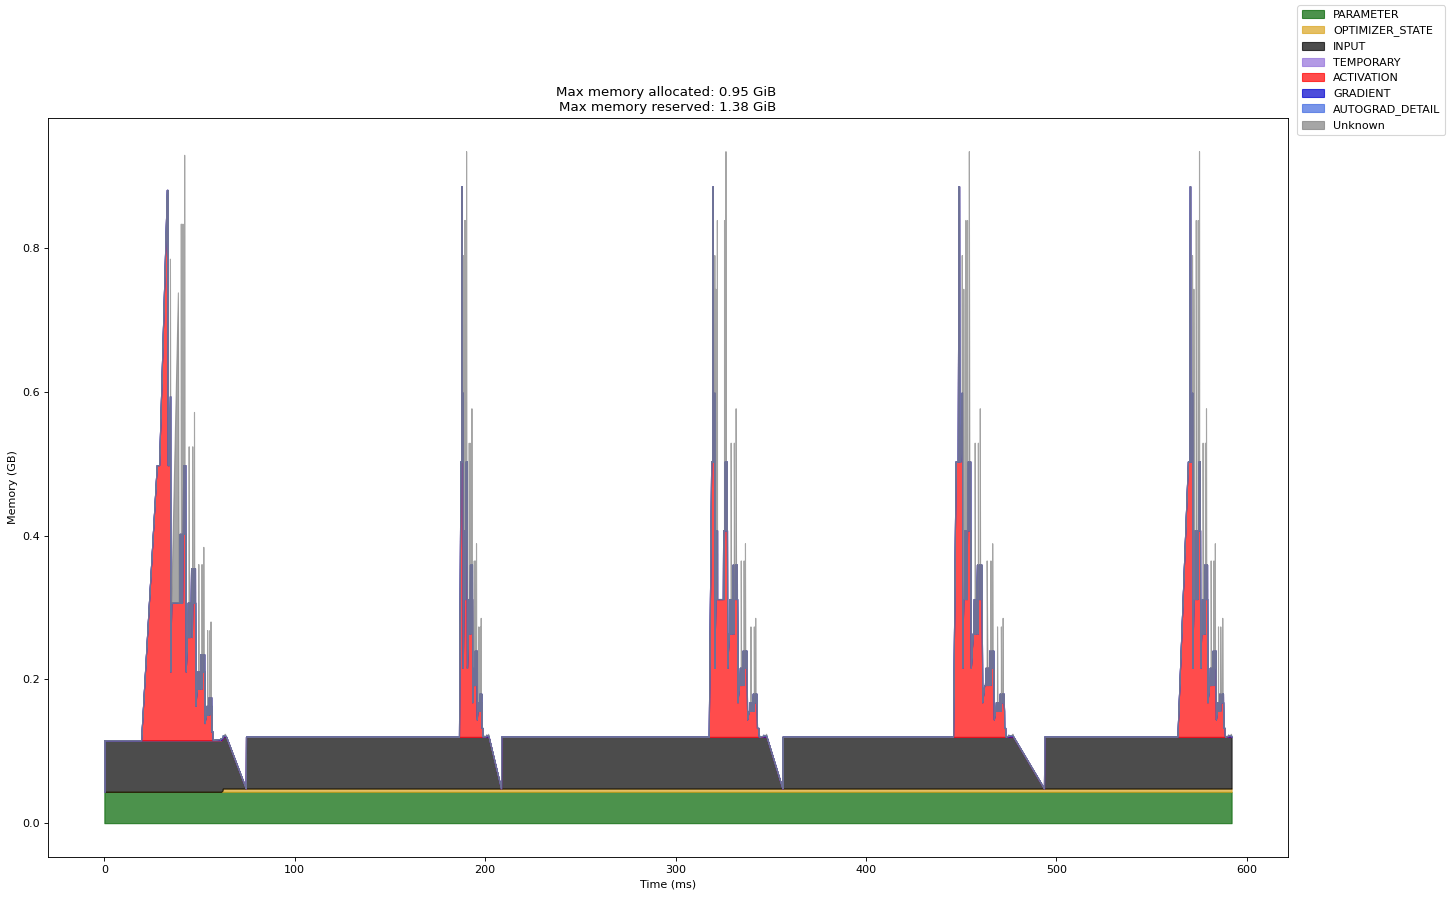

In [ ]:
batch_ids = None
num_workers = 4
break_after_num_batches = 10

plt.Figure(figsize=(10, 10))
batch_indices = None
batch_sizes = [128]
for batch_size in batch_sizes:
    model = ResnetCheckpointed()
    model.to(device)

    train_loader = torch.utils.data.DataLoader(tiny_imagenet_torch, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(tiny_imagenet_torch, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    fit(model, train_loader, val_loader, epochs=1, break_after_num_batches=break_after_num_batches, title=f"checkpointed_batch_size_{batch_size}")
    
    print(f"Proccessed for batch size {batch_size}")
    # clear memory
    del model
    del train_loader
    del val_loader
    clear_cuda_memory()
    time.sleep(10)




